# Langevin on checkboard

In [2]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = 'cuda:0'
torch.cuda.set_device(0)

DCGAN Toy dataset

In [3]:
from typing import Optional
from typing_extensions import Literal

def gan_loss(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Имплементирует подсчет лосса для генератора и дискриминатора.
  '''
  if by=='generator':
    # возвращает лосс генератора
    return torch.log(1 - generated_objects_scores).mean()
  elif by == 'discriminator':
    # возвращает лосс дискриминатора
    return -torch.log(1 - generated_objects_scores).mean() - torch.log(real_objects_scores).mean()



def gan_loss_nonsaturating(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Имплементирует подсчет лосса для генератора и дискриминатора.
  '''
  if by=='generator':
    # возвращает лосс генератора
    return -torch.log(generated_objects_scores).mean()
  elif by == 'discriminator':
    # возвращает лосс дискриминатора
    return -torch.log(1 - generated_objects_scores).mean() - torch.log(real_objects_scores).mean()



def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt,
              loss_func, prior,
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):
    '''
    Имплементирует подсчет лосса для генератора и дискриминатора.
    '''
    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # берем реальные объекты
            real_objects, y = batch
            real_objects = real_objects.to(device)
            y = y.to(device)
            
            # генерируем новые объекты
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects, ))
            gen_objects = gen(z, y)

            # считаем скоры
            real_objects_scores, gen_objects_scores = torch.split(discr(
                torch.cat([real_objects, gen_objects], dim=0), 
                torch.cat([y, y], dim=0)), num_objects)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
              # делаем шаг обучения генератора
              gen_opt.zero_grad()
              gen_loss = loss_func(real_objects_scores, gen_objects_scores, 'generator')
              gen_loss.backward()
              gen_opt.step()
              gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
              # делаем шаг обучения дискриминатора
              discr_opt.zero_grad()
              discr_loss = loss_func(real_objects_scores, gen_objects_scores, 'discriminator')
              discr_loss.backward()
              discr_opt.step()
              discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                gen.eval()
                if data_type == '2d':
                  plt.subplot(1, 3, 3)
                  with torch.no_grad():
                    z = prior.sample((5096, ))
                    sampled_2d = gen(z)
                  plt.scatter(
                    sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1)
                elif data_type == 'mnist':
                  with torch.no_grad():
                    z = prior.sample((100, ))
                    sampled_mnist = gen(z, torch.arange(100).cuda() % 10)

                  for i in range(100):
                    plt.subplot(10, 30, 30 * (i // 10) + 21 + (i % 10))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

                plt.show()
                gen.train()
                
    gen.eval()
    discr.eval()

# Training gan

In [ ]:
def sample_2d_data(n_samples):
  z = torch.randn(n_samples, 2)
  x1 = torch.rand(n_samples) *10 - 5
  x2_ = torch.rand(n_samples) - torch.randint(0, 5, (n_samples,), dtype=torch.float) * 2
  x2 = x2_ + x1.floor() % 2+3
  return torch.stack([x1, x2], dim=1) * 2
chess_data_train = sample_2d_data(20000)
chess_data_test = sample_2d_data(2000)

In [4]:
def sample_2d_data(n_samples):
  z = torch.randn(n_samples, 2)
  x1 = torch.rand(n_samples) *6 - 3
  x2_ = torch.rand(n_samples) - torch.randint(0, 3, (n_samples,), dtype=torch.float) * 2
  x2 = x2_ + x1.floor() % 2+1
  return torch.stack([x1, x2], dim=1) * 2
chess_data_train = sample_2d_data(20000)
chess_data_test = sample_2d_data(2000)

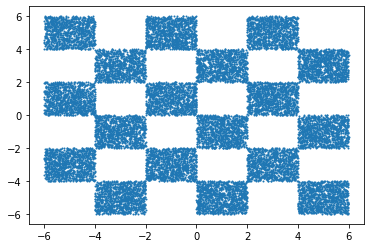

In [5]:
plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1)

In [5]:
class Dataset2d:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

In [7]:
class Generator2d(nn.Module):
  def __init__(self, lat_size):
    super(Generator2d, self).__init__()
    self.lat_size = lat_size

    self.net = nn.Sequential(
        nn.Linear(lat_size, 64), 
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 2))

  def forward(self, z: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    Для батча латентных кодов z возвращает батч сгенерированных объектов
    '''
    return self.net(z)

class Discriminator2d(nn.Module):
  def __init__(self):
    super(Discriminator2d, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(2, 64), 
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid())

  def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    Для батча объектов возвращает их скоры.
    '''
    return self.net(x)

Training the gan 

In [ ]:
# создадим сети, оптимизаторы, прайор и даталоадер

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(chess_data_train, dtype=torch.float32), 
              torch.zeros_like(chess_data_train)),
              batch_size=64, shuffle=True, num_workers=1)


latent_size=100
gen_2d = Generator2d(latent_size)
gen_2d.cuda()

discr_2d = Discriminator2d()
discr_2d.cuda()

prior_2d = torch.distributions.Normal(torch.zeros(latent_size).cuda(), torch.ones(latent_size).cuda())
#prior_2d_uniform = torch.distributions.Uniform(low = torch.tensor([-6,-6])),high= torch.tensor([6,6])
gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))
train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d, gan_loss, prior_2d,
          num_epochs=20000, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

In [ ]:
# создадим сети, оптимизаторы, прайор и даталоадер

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(chess_data_train, dtype=torch.float32), 
              torch.zeros_like(chess_data_train)),
              batch_size=64, shuffle=True, num_workers=1)

gen_2d = Generator2d(5)
gen_2d.cuda()

discr_2d = Discriminator2d()
discr_2d.cuda()

prior_2d = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).cuda())
#prior_2d_uniform = torch.distributions.Uniform(low = torch.tensor([-6,-6])),high= torch.tensor([6,6])
gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Using training with  non saturating loss

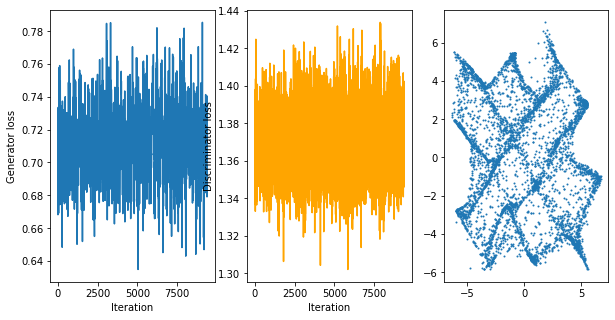

In [ ]:
tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(chess_data_train, dtype=torch.float32), 
              torch.ones_like(chess_data_train)),
              batch_size=64, shuffle=True, num_workers=1)
train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d, gan_loss_nonsaturating, prior_2d,
          num_epochs=30, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

# Langevin dynamics

Langevin dynamics

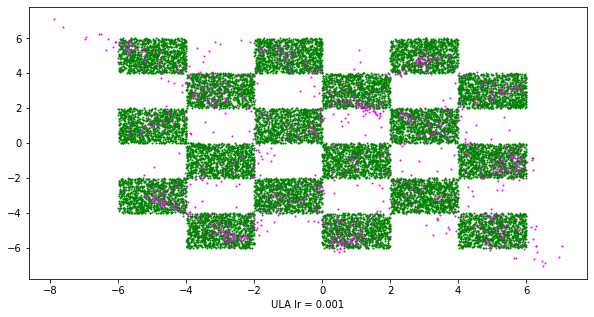

In [ ]:
#Langevin dynamics look at modes
import imageio
discr_2d.eval()
gen_2d.eval()


def GetScore(z):
  return discr_2d(gen_2d(z))

def Score_gradient(z):
  z_new=z.clone().requires_grad_(True)
  score_z_new=GetScore(z_new)
  gradients = torch.autograd.grad(outputs=score_z_new, inputs=z_new,
                              grad_outputs=torch.ones_like(score_z_new),
                              create_graph=False, retain_graph=False, only_inputs=True)[0]
  return gradients.detach()
z_init = prior_2d.sample((1000, ))


images_list=[]
z_noize=z_init.clone()
lr_grad=1e-3
for i in range(1000):
    z_noize=z_noize-0.5*lr_grad*Score_gradient(z_noize)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
    sampled_2d=gen_2d(z_noize)
    if i%10==0:
      clear_output(wait=True)
      plt.figure(figsize=(10, 5))
      if i==0:
        plt.title('Begin')
               
      plt.subplot(1, 1, 1)   
      plt.xlabel(f'ULA lr = {lr_grad}')
      plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
      plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                      sampled_2d[:, 1].cpu().detach().numpy(),
                      s=1, c='magenta')
      plt.savefig(f'/content/drive/MyDrive/gan_checkerboard/checkerboard{i}.png')
      images_list.append(imageio.imread(f'/content/drive/MyDrive/gan_checkerboard/checkerboard{i}.png'))
      
 
      plt.show()
imageio.mimsave(f'/content/drive/MyDrive/gan_checkerboard/ula_mi_checkerboard_lr{lr_grad}.gif',images_list)

Training with vanila gan loss for 10 epochs

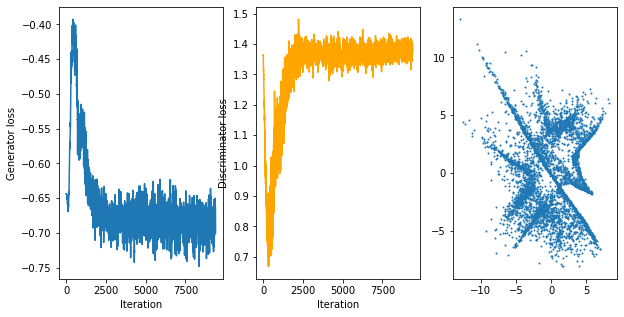

In [ ]:

train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d, gan_loss, prior_2d,
          num_epochs=30, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

Langevin on 6 by 6 checkerboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Langevin with vanilla loss latent dimension equal to 2

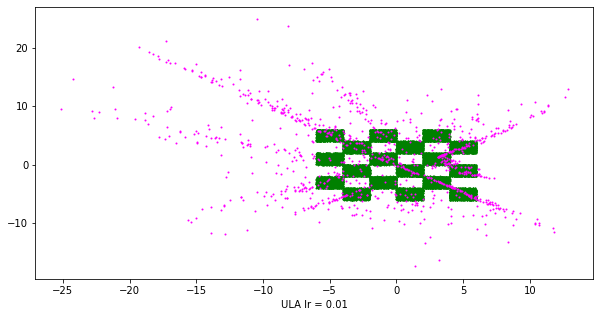

In [ ]:
#Langevin dynamics look at modes
import imageio
discr_2d.eval()
gen_2d.eval()


def GetScore(z):
  return discr_2d(gen_2d(z))

def Score_gradient(z):
  z_new=z.clone().requires_grad_(True)
  score_z_new=GetScore(z_new)
  gradients = torch.autograd.grad(outputs=score_z_new, inputs=z_new,
                              grad_outputs=torch.ones_like(score_z_new),
                              create_graph=False, retain_graph=False, only_inputs=True)[0]
  return gradients.detach()
z_init = prior_2d.sample((1000, ))


images_list=[]
z_noize=z_init.clone()
lr_grad=1e-2
for i in range(500):
    z_noize=z_noize+0.5*lr_grad*Score_gradient(z_noize)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
    sampled_2d=gen_2d(z_noize)
    if i%10==0:
      clear_output(wait=True)
      plt.figure(figsize=(10, 5))
      if i==0:
        plt.title('Begin')
               
      plt.subplot(1, 1, 1)   
      plt.xlabel(f'ULA lr = {lr_grad}')
      plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
      plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                      sampled_2d[:, 1].cpu().detach().numpy(),
                      s=1, c='magenta')
      plt.savefig(f'/content/drive/MyDrive/gan_checkerboard/checkerboard{i}.png')
      images_list.append(imageio.imread(f'/content/drive/MyDrive/gan_checkerboard/checkerboard{i}.png'))
      
 
      plt.show()
imageio.mimsave(f'/content/drive/MyDrive/gan_checkerboard/ula_checkerboard_lr{lr_grad}.gif',images_list)

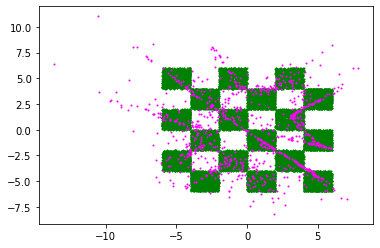

In [ ]:
with torch.no_grad():
  z = prior_2d.sample((1024, ))
  sampled_2d = gen_2d(z)
plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1, c='magenta')

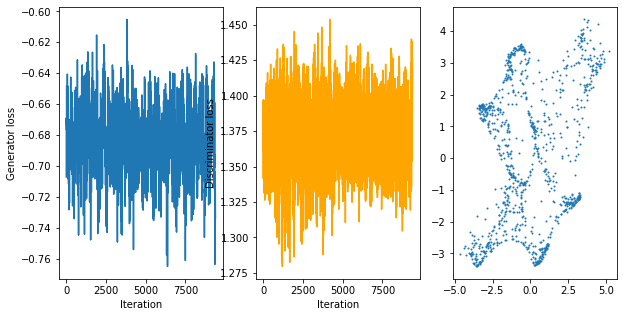

In [ ]:
tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(chess_data_train, dtype=torch.float32), 
              torch.ones_like(chess_data_train)),
              batch_size=64, shuffle=True, num_workers=1)

train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d, gan_loss, prior_2d,
          num_epochs=30, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

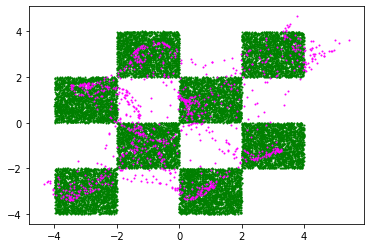

In [ ]:
with torch.no_grad():
  z = prior_2d.sample((1024, ))
  sampled_2d = gen_2d(z)
plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1, c='magenta')

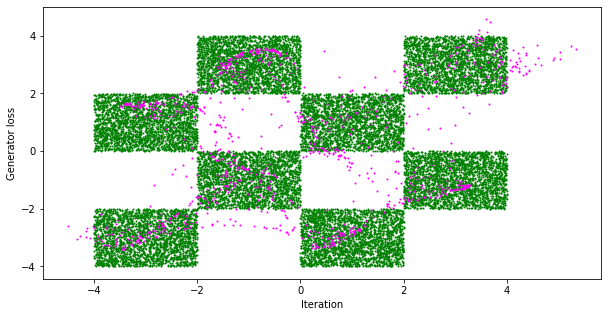

In [ ]:
#Langevin dynamics look at modes

discr_2d.eval()
gen_2d.eval()


def GetScore(z):
  return discr_2d(gen_2d(z))

def Score_gradient(z):
  z_new=z.clone().requires_grad_(True)
  score_z_new=GetScore(z_new)
  gradients = torch.autograd.grad(outputs=score_z_new, inputs=z_new,
                              grad_outputs=torch.ones_like(score_z_new),
                              create_graph=False, retain_graph=False, only_inputs=True)[0]
  return gradients.detach()
z_init = prior_2d.sample((1024, ))



z_noize=z_init.clone()
lr_grad=1e-4
for i in range(100):
    z_noize=z_noize+0.5*lr_grad*Score_gradient(z_noize)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
    sampled_2d=gen_2d(z_noize)
    if i%10:
      clear_output(wait=True)
      plt.figure(figsize=(10, 5))
                  
      plt.subplot(1, 1, 1)
      plt.xlabel('Iteration')
      plt.ylabel('Generator loss')
      
      plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
      plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                      sampled_2d[:, 1].cpu().detach().numpy(),
                      s=1, c='magenta')
      plt.show()



Langevin with learning rate 1e-3

In [ ]:
lr_grad=1e-3
for i in range(100):
    z_noize=z_noize+0.5*lr_grad*Score_gradient(z_noize)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
    sampled_2d=gen_2d(z_noize)
    if i%10:
      clear_output(wait=True)
      plt.figure(figsize=(10, 5))
                  
      plt.subplot(1, 1, 1)
      plt.xlabel('Iteration')
      plt.ylabel('Generator loss')
      
      plt.scatter(chess_data_train[:, 0], chess_data_train[:, 1], s=1,c='green')
      plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
                      sampled_2d[:, 1].cpu().detach().numpy(),
                      s=1, c='magenta')
      plt.show()